In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
import csv
import random
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

import MusicGenreClassificationTool as mgc

In [3]:
mgc.extractFeaturesToCSV()

In [2]:
mgc.saveSpectrogramsAsPNG()

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
mgc.saveSpectrogramsAsNPZ()

Spectrograms (image)

In [10]:
image_size = tuple((224, 224))
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            #image = preprocess_input(image)
            #image = cv2.resize(image, image_size)
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('img_data')
print('loaded',len(samples),' samples')
print('classes',set(labels))

loaded 7997  samples
classes {'Hip-Hop', 'Pop', 'Rock', 'Instrumental', 'Experimental', 'Electronic', 'International', 'Folk'}


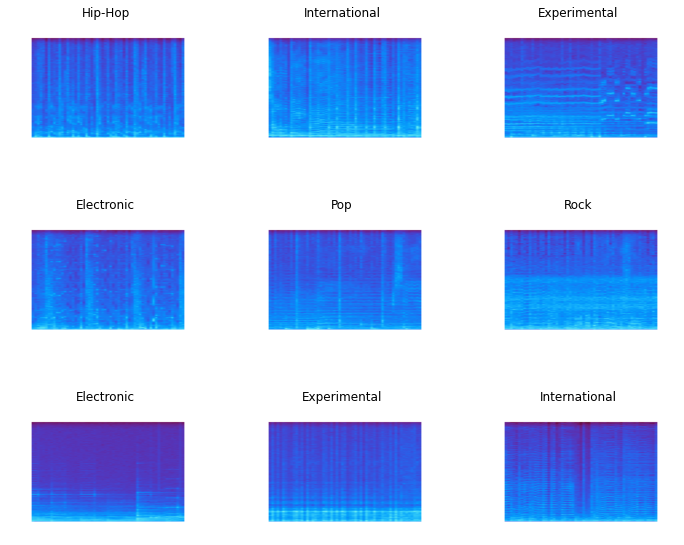

In [11]:
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

In [12]:
# one-hot labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Labels shape",labels.shape)
labels = labels.astype(float)

Labels shape (7997, 8)


In [14]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

input_shape = samples[0].shape

model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(8))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 288, 432, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 288, 432, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 144, 216, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 216, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 144, 216, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 108, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 72, 108, 32)      

In [15]:
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=42,stratify=labels, test_size=0.1)
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

(7997, 288, 432, 3)


In [16]:
model.fit(trainSamples, trainLabels, batch_size=64, epochs=3, validation_data=(testSamples,testLabels))  

Train on 7197 samples, validate on 800 samples
Epoch 1/3
7197/7197 [==============================] - 224s 31ms/sample - loss: 90.3720 - accuracy: 0.1241 - val_loss: 2.0794 - val_accuracy: 0.1250
Epoch 2/3
7197/7197 [==============================] - 230s 32ms/sample - loss: 2.0800 - accuracy: 0.1198 - val_loss: 2.0794 - val_accuracy: 0.1250
Epoch 3/3
7197/7197 [==============================] - 232s 32ms/sample - loss: 2.0795 - accuracy: 0.1216 - val_loss: 2.0794 - val_accuracy: 0.1250


Spectrograms (array)

(647, 128)


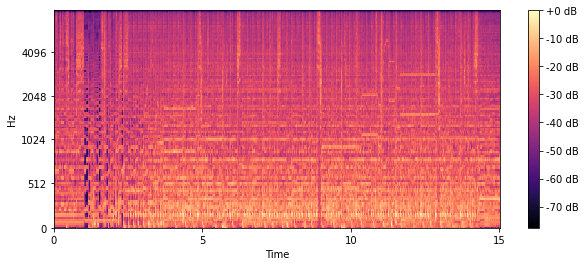

In [18]:
mgc.plot_spect('Samples/Electronic/3573.wav')

In [19]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [20]:
npzfile = np.load('data_arr.npz')
print(npzfile.files)
X_data = npzfile['arr_0']
y_data = npzfile['arr_1']
print(X_data.shape, y_data.shape)

['arr_0', 'arr_1']
(16, 640, 128) (16, 8)


Folk


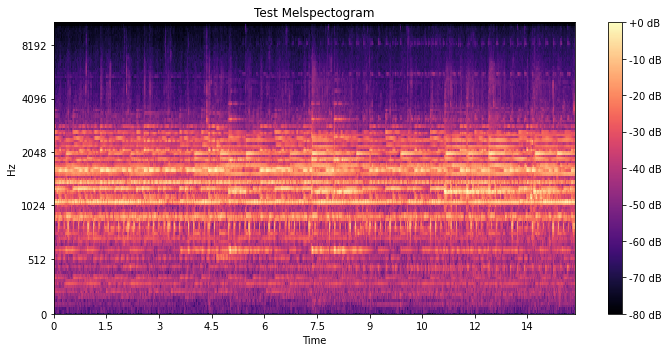

In [21]:
num = 5
spectogram = X_data[num]
genre = np.argmax(y_data[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

Features

In [22]:
data = pd.read_csv('features.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre
0,100497.wav,0.353043,0.129673,2755.159672,2803.714275,6168.963623,0.078604,-75.258896,74.126694,4.410441,...,8.927309,3.801457,9.203838,4.597521,10.896611,1.959311,4.754197,-4.429041,1.118927,Electronic
1,100522.wav,0.407598,0.150315,3378.180972,3044.019959,7018.677775,0.145420,-115.187874,51.246540,16.773762,...,-0.566564,-8.416990,-1.425384,-6.259008,-1.595107,-7.123302,2.054071,-5.817743,1.185415,Electronic
2,100535.wav,0.483198,0.143264,2876.901789,3107.373731,7019.375610,0.104418,-92.982857,83.841049,29.133919,...,1.207961,-2.715016,9.191577,-6.600711,5.597632,-3.499262,7.540925,0.510709,0.895847,Electronic
3,100536.wav,0.386117,0.213306,798.667722,1441.244469,1382.012939,0.021573,-184.218201,160.502899,7.311378,...,0.928298,-4.239233,5.076037,3.829957,4.814407,-1.802592,0.725051,-0.917639,1.366803,Electronic
4,100544.wav,0.440430,0.142198,3429.078898,3209.342129,7473.815918,0.131551,-101.427834,47.014378,15.408000,...,6.593324,-2.237442,4.057968,4.035399,0.657704,2.317587,1.788667,-1.452299,4.663561,Electronic


In [23]:
data.shape

(7997, 28)

In [24]:
data = data.drop(['filename'],axis=1)

In [25]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [26]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [28]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(8, activation='softmax'))

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128)

Train on 7197 samples
Epoch 1/20
7197/7197 [==============================] - 0s 52us/sample - loss: 1.8060 - accuracy: 0.3322
Epoch 2/20
7197/7197 [==============================] - 0s 10us/sample - loss: 1.6235 - accuracy: 0.4164
Epoch 3/20
7197/7197 [==============================] - 0s 10us/sample - loss: 1.5604 - accuracy: 0.4380
Epoch 4/20
7197/7197 [==============================] - 0s 11us/sample - loss: 1.5208 - accuracy: 0.4464
Epoch 5/20
7197/7197 [==============================] - 0s 11us/sample - loss: 1.4839 - accuracy: 0.4744
Epoch 6/20
7197/7197 [==============================] - 0s 11us/sample - loss: 1.4451 - accuracy: 0.4860
Epoch 7/20
7197/7197 [==============================] - 0s 10us/sample - loss: 1.4083 - accuracy: 0.5008
Epoch 8/20
7197/7197 [==============================] - 0s 11us/sample - loss: 1.3821 - accuracy: 0.5090
Epoch 9/20
7197/7197 [==============================] - 0s 11us/sample - loss: 1.3498 - accuracy: 0.5231
Epoch 10/20
7197/7197 [==========

In [31]:
test_loss, test_acc = model.evaluate(X_test,y_test)

800/800 [==============================] - 0s 106us/sample - loss: 1.6939 - accuracy: 0.4075
